## Building a regression model

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date
import matplotlib.ticker as ticker

In [2]:
from datetime import date, timedelta
import pandas as pd

def get_day_cases(end_date=date.today()):
    """
    Gets day-by-day case numbers.

    Input: end date (optional)
    Output: array of dataframes, indexed from 0 = 4/12/20
    """
    START_DATE = date(2020, 4, 12)
    GIT_REPO_PATH = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/'
    num_days = (end_date - START_DATE).days
    dfs = []
    for i in range(num_days):
        year, mo, day = (START_DATE + timedelta(days=i)).isoformat().split('-')
        file_name = '{0}-{1}-{2}.csv'.format(mo, day, year)
        dfs.append(pd.read_csv(GIT_REPO_PATH + file_name, error_bad_lines=False))
    for day in range(len(dfs)):
        dfs[day] = dfs[day][dfs[day]['Country_Region'] == 'US']
        banned_territories = ['Diamond Princess', 'District of Columbia', 'Grand Princess', 'Guam', 'American Samoa',
                              'Northern Mariana Islands', 'Recovered', 'Virgin Islands', 'Puerto Rico']
        dfs[day] = dfs[day][~dfs[day]['Province_State'].isin(banned_territories)].reset_index().drop(columns=['index'])
        dfs[day]['Recovered'] = dfs[day]['Confirmed'] = dfs[day]['Active']
    return dfs


We'll be taking a look at death rate over time. We'll compile all the days of case information (similar to 4.18_states.csv, but for all dates up until today) to assemble our training matrix X.

In [3]:
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',
           error_bad_lines=False)
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
                   error_bad_lines=False)
#cases['FIPS'] = cases['FIPS'].astype('int')
day_cases = get_day_cases()
counties = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv',
                      error_bad_lines=False)
county_cases = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_level/processed/nytimes_infections/nytimes_infections.csv',
                          error_bad_lines=False)

death_keep = [col+'_deaths' if (col in cases.columns and col != 'FIPS') else col for col in deaths.columns]
cases_keep = [col+'_cases' for col in cases.columns[12:]]
cases_and_deaths = cases.merge(deaths, on='FIPS', suffixes=('_cases', '_deaths'))[death_keep+cases_keep]
renamer = lambda name: name if (type(name) != str or '/' in name or '_deaths' not in name) else name[:-7]
cases_and_deaths = cases_and_deaths.rename(columns=renamer)
cases_and_deaths.head()

valid_territories = cases_and_deaths[(cases_and_deaths['Lat'] > 0) & ~np.isnan(cases_and_deaths['FIPS'])]
valid_territories.loc[:, 'FIPS'] = valid_territories['FIPS'].astype('int')
valid_counties = counties[~counties['countyFIPS'].isin(['City1', 'City2'])]
valid_counties.loc[:, 'countyFIPS'] = valid_counties['countyFIPS'].astype('int')

county_all = valid_counties.merge(valid_territories, left_on='countyFIPS', right_on='FIPS')
county_all = county_all.drop(columns=['Lat', 'Long_', 'Province_State', 'Country_Region', 'FIPS'])

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
get_trait_ts = lambda terr, trait: [day_cases[day][trait][terr] for day in range(len(day_cases))]

In [5]:
mort_rates = np.zeros((50, len(day_cases)))
for terr in range(50):
    mort_rates[terr, :] = get_trait_ts(terr, 'Mortality_Rate')
start, end = datetime.datetime(2020, 4, 12), datetime.datetime(2020, 5, 12)
mort_matrix = pd.DataFrame(mort_rates, index=day_cases[0]['Province_State'], columns = pd.date_range(start, end))


Now that we have our csv assembled, we can begin creating our model.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn import metrics


def cross_validate_acc(model, X, y):
    model = clone(model, safe=False)
    five_fold = KFold(n_splits=5)
    acc_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y[tr_ind])
        acc_values.append(model.score(X.iloc[va_ind,:], y[va_ind]))
    return np.mean(acc_values)

def cross_validate_rmse(model, X, y):
    model = clone(model, safe=False)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

We will break down the immense task of predicting COVID-19 incidence by examining states at a time. The funcion below will assemble our training matrix with the proper state and features. These features were selected after examining cross validation RMSE and are the most descriptive we could find within our own datasets.

In [7]:
def get_single_state(state='California'):
    features_of_interest = ['Confirmed', 'Deaths', 'Active', 'Incident_Rate', 'Mortality_Rate']
    state_df = pd.DataFrame({'day': np.zeros(5)})
    for df in day_cases:
        row = df.loc[df['Province_State'] == state]
        date = pd.to_datetime(row['Last_Update'].values[0])
        state_df[date] = np.array(row[features_of_interest].values[0])
    state_df = state_df.drop('day', axis =1)
    state_df.index = features_of_interest
    return state_df.T

def get_country():
    nation_df = pd.DataFrame()
    for state in day_cases[0]['Province_State']:
        df = get_single_state(state)
        nation_df = nation_df.append(df)
    return nation_df

def create_model(state='California', nation=False, future=13, past=13):
    model = LinearRegression()
    matrix = get_single_state(state)
    X_train = matrix.iloc[-2*past:-1*past, :]
    y_train = matrix['Mortality_Rate'][-1*past:]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    print('Training Error:', rmse(y_train, y_hat))
    print('Cross Validation Error', cross_validate_rmse(model, X_train, y_train))
    return model


model13 = create_model()
def plot_predictions(model, matrix, state='State Name Here', forecast=20):
    guess = model.predict(matrix.iloc[-1 * forecast:,:])
    x = range(forecast)
    
    ax = sns.scatterplot(x =x, y=guess)
    ax.set(xlabel='Days Past '+str(date.today()), ylabel='Mortality Rate (Deaths Per 100 Cases)')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set(title='Mortality Rate over Time, ' + state)
    plt.show()



Training Error: 0.02065840740756149
Cross Validation Error 0.03390570018208915


The training error and cross validation error are fairly good, considering the magnitude of our data set (on the order of 10^1). The function plot_predictions() will take a model, a state, and a forecast (number of days) in order to predict the mortality rate in the future.

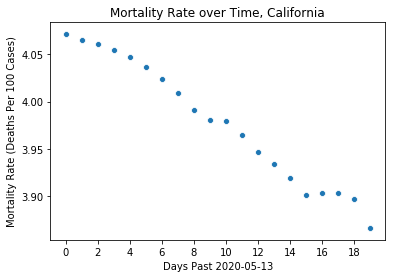

In [8]:
plot_predictions(model13, get_single_state('California'), state='California')

#### Note that our model suffers greatly when the change over the given number of days is extreme or quite drastic. NY is a good example of our momdel failing.

In [9]:
!pip install plotly

You should consider upgrading via the '/home/victor/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as mpatches
%matplotlib inline

In [11]:
death_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
deaths_df = pd.read_csv(death_url, error_bad_lines=False)

cases_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
cases_df = pd.read_csv(cases_url, error_bad_lines=False)

states_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-08-2020.csv"
states_df = pd.read_csv(states_url, error_bad_lines=False)

# county_level = "https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv"
county_df = pd.read_csv('./covid19/small_abridged.csv', error_bad_lines=False)

In [12]:
deaths_df.head()

UID iso2 iso3  code3  FIPS Admin2            Province_State Country_Region  \
0   16   AS  ASM     16  60.0    NaN            American Samoa             US   
1  316   GU  GUM    316  66.0    NaN                      Guam             US   
2  580   MP  MNP    580  69.0    NaN  Northern Mariana Islands             US   
3  630   PR  PRI    630  72.0    NaN               Puerto Rico             US   
4  850   VI  VIR    850  78.0    NaN            Virgin Islands             US   

       Lat     Long_  ... 5/4/20  5/5/20  5/6/20  5/7/20  5/8/20  5/9/20  \
0 -14.2710 -170.1320  ...      0       0       0       0       0       0   
1  13.4443  144.7937  ...      5       5       5       5       5       5   
2  15.0979  145.6739  ...      2       2       2       2       2       2   
3  18.2208  -66.5901  ...     97      99      99     102     107     108   
4  18.3358  -64.8963  ...      4       4       4       4       4       4   

   5/10/20  5/11/20  5/12/20  5/13/20  
0        0        0        0        0  
1        5        5        5        5  
2        2        2        2        2  
3      111      113      114      115  
4        4        5        6        6  

[5 rows x 125 columns]

# Data Cleaning
We took in the unabridged counties dataset, and selected useful columns outside of this notebook.

In [13]:
#drop territories
cases = cases_df[~cases_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
cases = cases[~cases['FIPS'].isnull()] 
#change FIPS to integer type
cases['FIPS'] = cases['FIPS'].astype(int)
#Only dealing with states, so county is better name
cases = cases.rename(columns={'Admin2':'County'}) 
#the country is US, unnecessary
cases = cases.drop(columns=['Country_Region'])
cases.head()

#repeat for deaths

#drop territories
deaths = deaths_df[~deaths_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
deaths = deaths[~deaths['FIPS'].isnull()] 
#change FIPS to integer type
deaths['FIPS'] = deaths['FIPS'].astype(int)
#Only dealing with states, so county is better name
deaths = deaths.rename(columns={'Admin2':'County'})
deaths.head()

county = county_df.rename(columns={'countyFIPS':'FIPS', 'CountyName':'County'}).drop(columns=['Unnamed: 0'])
# drop rows that are not counties. There's only two: NYC and Kansas City, so shouldn't matter much
county = county[county['FIPS'].str.isnumeric()]
county['FIPS'] = county['FIPS'].astype(int)
county.head()

county_cases_deaths = pd.read_csv('county_info_cases_deaths.csv')
county_cases_deaths.head(3)


Unnamed: 0  countyFIPS  STATEFP  COUNTYFP CountyName StateName    State  \
0           0        1001      1.0       1.0    Autauga        AL  Alabama   
1           1        1003      1.0       3.0    Baldwin        AL  Alabama   
2           2        1005      1.0       5.0    Barbour        AL  Alabama   

         lat        lon  POP_LATITUDE  ...  5/1/20_cases 5/2/20_cases  \
0  32.540091 -86.645649     32.500389  ...            42           45   
1  30.738314 -87.726272     30.548923  ...           175          181   
2  31.874030 -85.397327     31.844036  ...            42           43   

  5/3/20_cases  5/4/20_cases  5/5/20_cases  5/6/20_cases  5/7/20_cases  \
0           48            53            53            58            61   
1          187           188           189           196           205   
2           45            45            47            47            51   

   5/8/20_cases  5/9/20_cases  5/10/20_cases  
0            67            68             74  
1           208           216            222  
2            53            58             59  

[3 rows x 314 columns]

The following functions make it easy to combine the time series of cases with county data. The following outputs state coronavirus cases/deaths, with the granularity of counties, and merged with county demographic data found in the unabridged county dataset.

In [14]:
def create_state_cases_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_cases = cases[cases['Province_State'] == state]
    state_cases = state_counties.merge(state_cases, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_cases[~state_cases['County_x'].isna()]

def create_state_deaths_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_deaths = deaths[deaths['Province_State'] == state]
    state_deaths = state_counties.merge(state_deaths, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_deaths[~state_deaths['County_x'].isna()]

california_cases = create_state_cases_with_county_data('California')
california_deaths = create_state_deaths_with_county_data('California')

# Exploratory Data Analysis
### Finding promising factors that are related to COVID-19 cases or fatalities

In [15]:
def date_columns(df, not_date_columns=False):
    """returns list of column names if they don't match regex for a date (filters out time series)"""
    columns = df.columns.str.contains(r'\d\/[\d]{1,2}\/\d\d')
    if not_date_columns:
        return [x for x in (~columns)*df.columns.values if x]

    return [x for x in columns*df.columns.values if x]

def find_correlations(df, correlate_with, columns_to_avoid='Default', highest_n=15):
    #Following columns are mostly population (and repeat info), must be normalized before correlating
    if columns_to_avoid == 'Default':
        columns_to_avoid = ['PopMale<52010', 'PopFmle<52010',
               'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
               'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
               'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
               'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
               'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
               'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
               'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
               'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
               'PopMale>842010', 'PopFmle>842010',  'PopTotalMale2017',
                'PopTotalFemale2017','3-YrMortalityAge<1Year2015-17',
                '3-YrMortalityAge1-4Years2015-17',
                '3-YrMortalityAge5-14Years2015-17',
                '3-YrMortalityAge15-24Years2015-17',
                '3-YrMortalityAge25-34Years2015-17',
                '3-YrMortalityAge35-44Years2015-17',
                '3-YrMortalityAge45-54Years2015-17',
                '3-YrMortalityAge55-64Years2015-17',
                '3-YrMortalityAge65-74Years2015-17',
                '3-YrMortalityAge75-84Years2015-17',
                '3-YrMortalityAge85+Years2015-17',  'Poverty Num All Ages 2018',
                'Poverty Num Ages 0-17 2018',
                'Poverty Num Ages 5-17 2018',
                'mortality2015-17Estimated',
                '3-YrDiabetes2015-17', 
                "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', 
                '#Hospitals', '#ICU_beds', 'MedicareEnrollment,AgedTot2017',
                'HPSAUnderservedPop', 'HPSAUnderservedPop.1', 'HPSAServedPop',
                'HPSAPercentPoverty', 'StrokeMortality', 'lon', 'Long_', 'lat', 'Lat',
                '#EligibleforMedicare2018', '#FTEHospitalTotal2017', 'PopulationEstimate65+2017',
                'Population', 'CensusPopulation2010']
    # ignore the dates as well
    columns_to_avoid += date_columns(df)
    # only correlate with quantitative variables
    numerics = df.select_dtypes(include=[np.number])
    corr, log_normal_corr, log_log_corr, normal_log_corr = [], [], [], []
    correlate_with_logged = np.log(correlate_with)
    # loop through all columns, calculating correlations
    for col in numerics:
        column = df[col]
        if col in columns_to_avoid or np.mean(column.isna()) > 0.5: # skip if to_avoid or is mostly nan
            continue
        corr.append((col, column.corr(correlate_with)))
        log_normal_corr.append((col, np.log(column).corr(correlate_with)))
        log_log_corr.append((col, np.log(column).corr(correlate_with_logged)))
        normal_log_corr.append((col, column.corr(correlate_with_logged)))
        
    def highest_n_columns(corrs):
        """ Return list of length highest_n, of tuples containing column name, correlation,
        sorted descending by abs(correlation)"""
        return sorted([x for x in corrs if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:highest_n]
    corr = highest_n_columns(corr)
    log_normal_corr = highest_n_columns(log_normal_corr)
    log_log_corr = highest_n_columns(log_log_corr)
    normal_log_corr = highest_n_columns(normal_log_corr)
    return corr, log_normal_corr, log_log_corr, normal_log_corr

In [16]:
def plot_correlations(df, corrs, corr_with, title):
    """create scatter plot between corrs columns and corr_with column, with line of best fit"""
    fig, axes = plt.subplots((len(corrs) + 2)//3, 3, figsize=(15, 17))
    for i in range(len(corrs)):
        col = corrs[i][0]
        ax = axes[i//3][i%3]
        x=df[col]
        y=corr_with
        sns.regplot(x=x,
                    y=y,
                    ax=ax,
                    fit_reg=True
                   )
        ax.set_title("Correlation: {}".format(x.corr(y).round(3)))
        ax.set_ylim(bottom=np.min(y) - np.std(y)/2, top=np.max(y) + np.std(y)/2)
        ax.set_xlim(left=np.min(x) - np.std(x)/2, right=np.max(x) + np.std(x)/2)
        ax.set_ylabel('County Coronavirus Cases per Capita')
        ax.set_xlabel(col, fontsize=18)

    fig.suptitle(title, fontsize=25)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


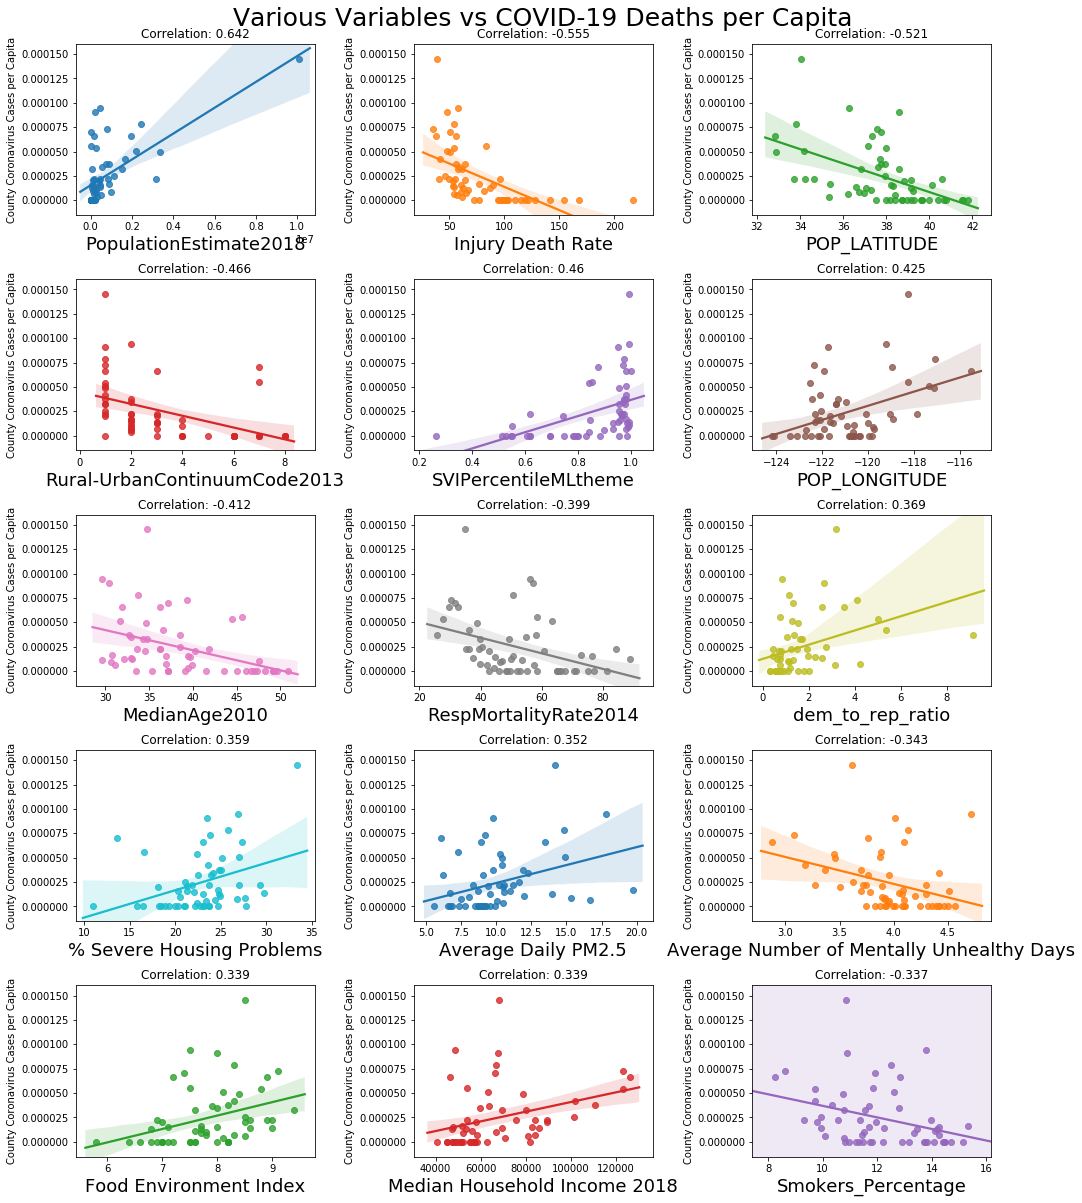

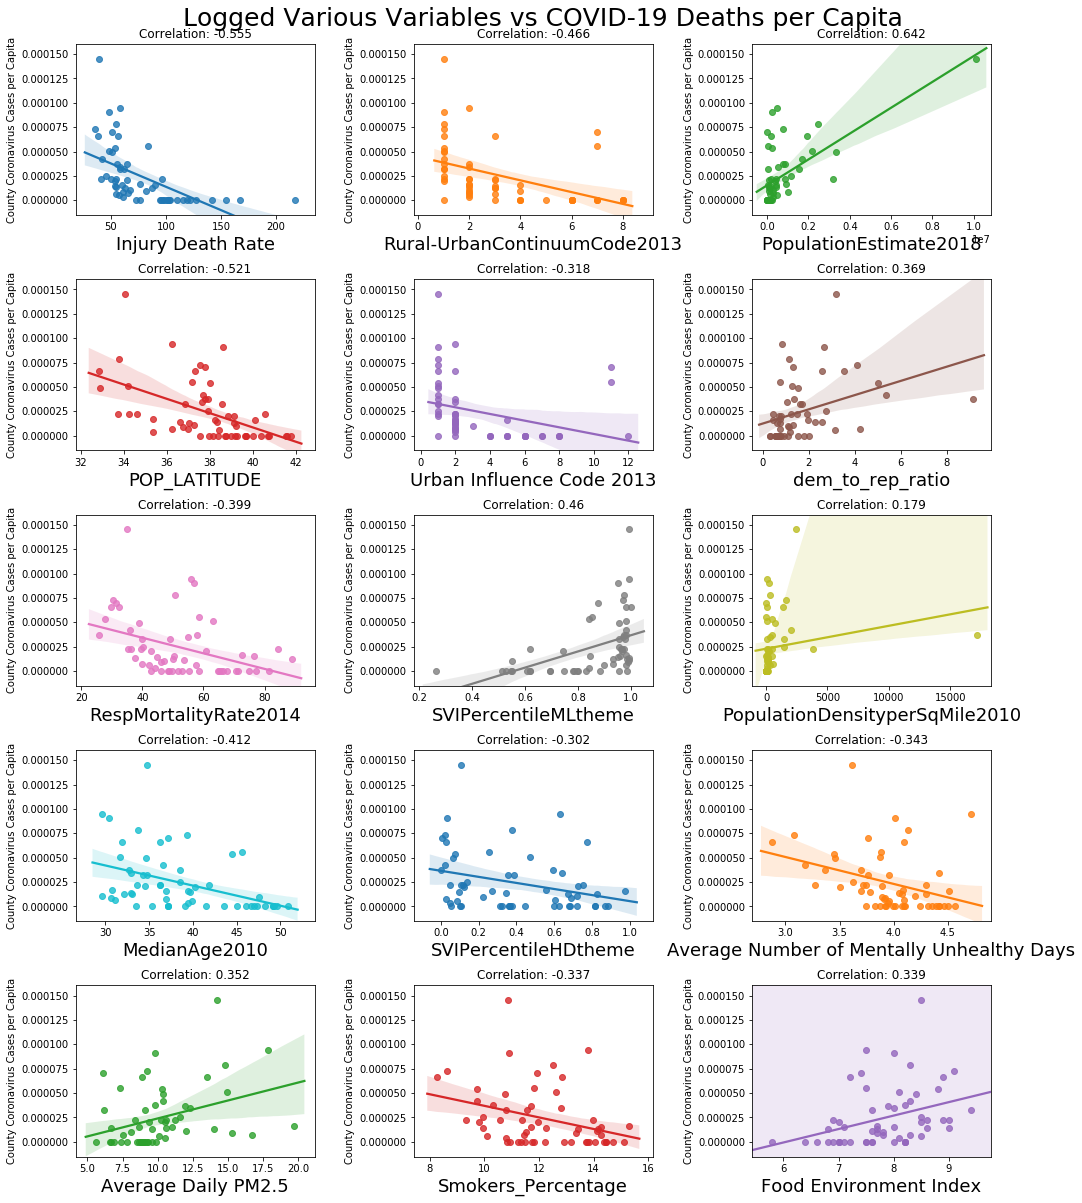

In [17]:
#Death Correlations
deaths_per_capita=california_deaths['5/8/20']/california_deaths['PopulationEstimate2018']
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_deaths, deaths_per_capita)
# Plot variables vs covid deaths per capita. Each point is a county
plot_correlations(california_deaths, corr, deaths_per_capita, title="Various Variables vs COVID-19 Deaths per Capita")
# Plot the log of variables vs covid deaths per capita. Each point is county
plot_correlations(california_deaths, log_normal_corr, deaths_per_capita, title="Logged Various Variables vs COVID-19 Deaths per Capita")

It seems like there are a lot of outliers and messy data, likely because of the uneven spread and outbreaks. There does seem to be promising variables, like SVI Percentiles, which measure social vulnerability.

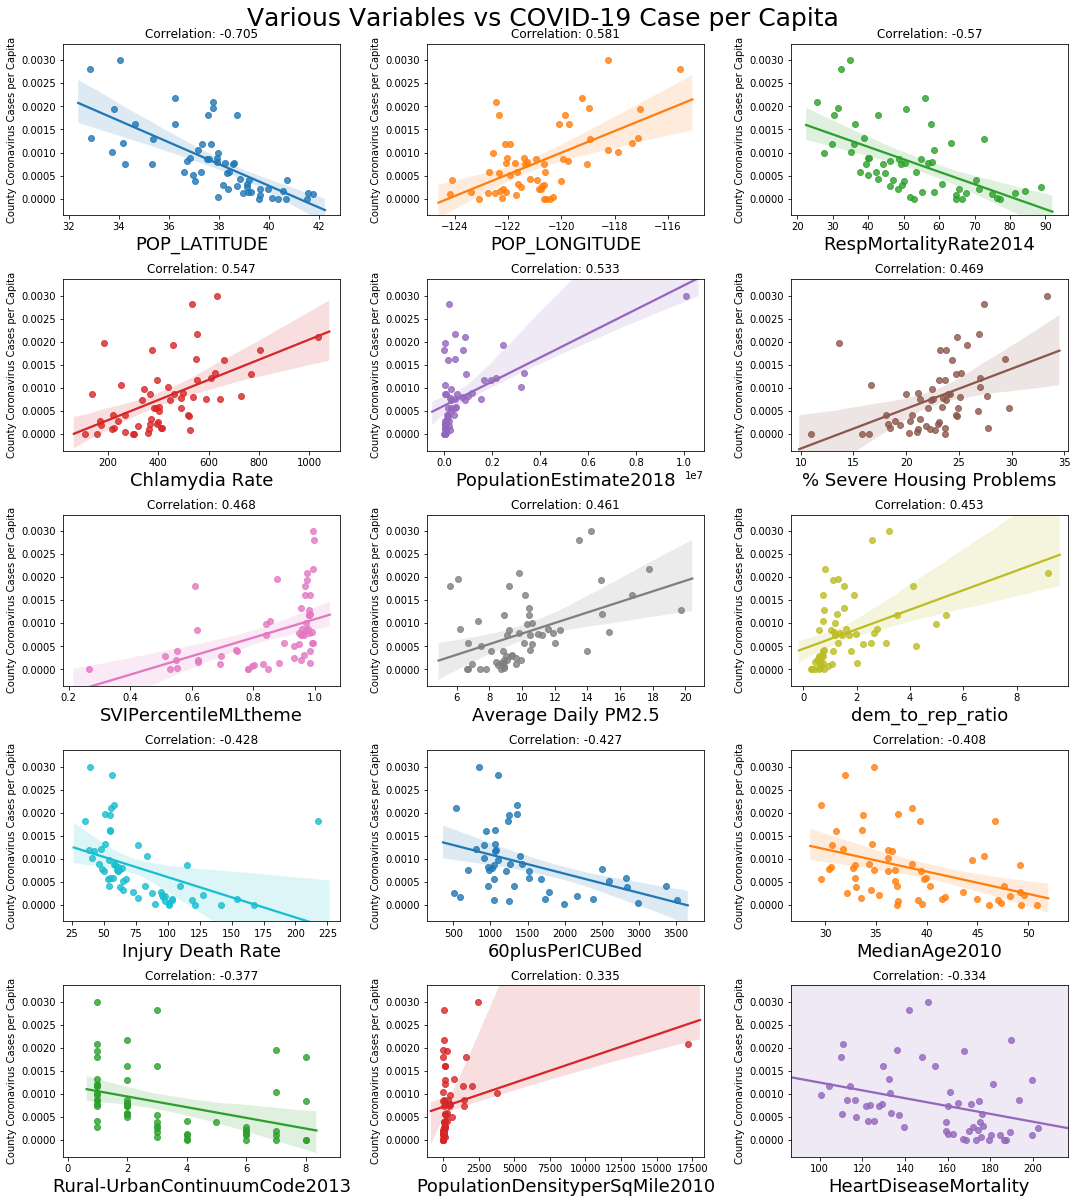

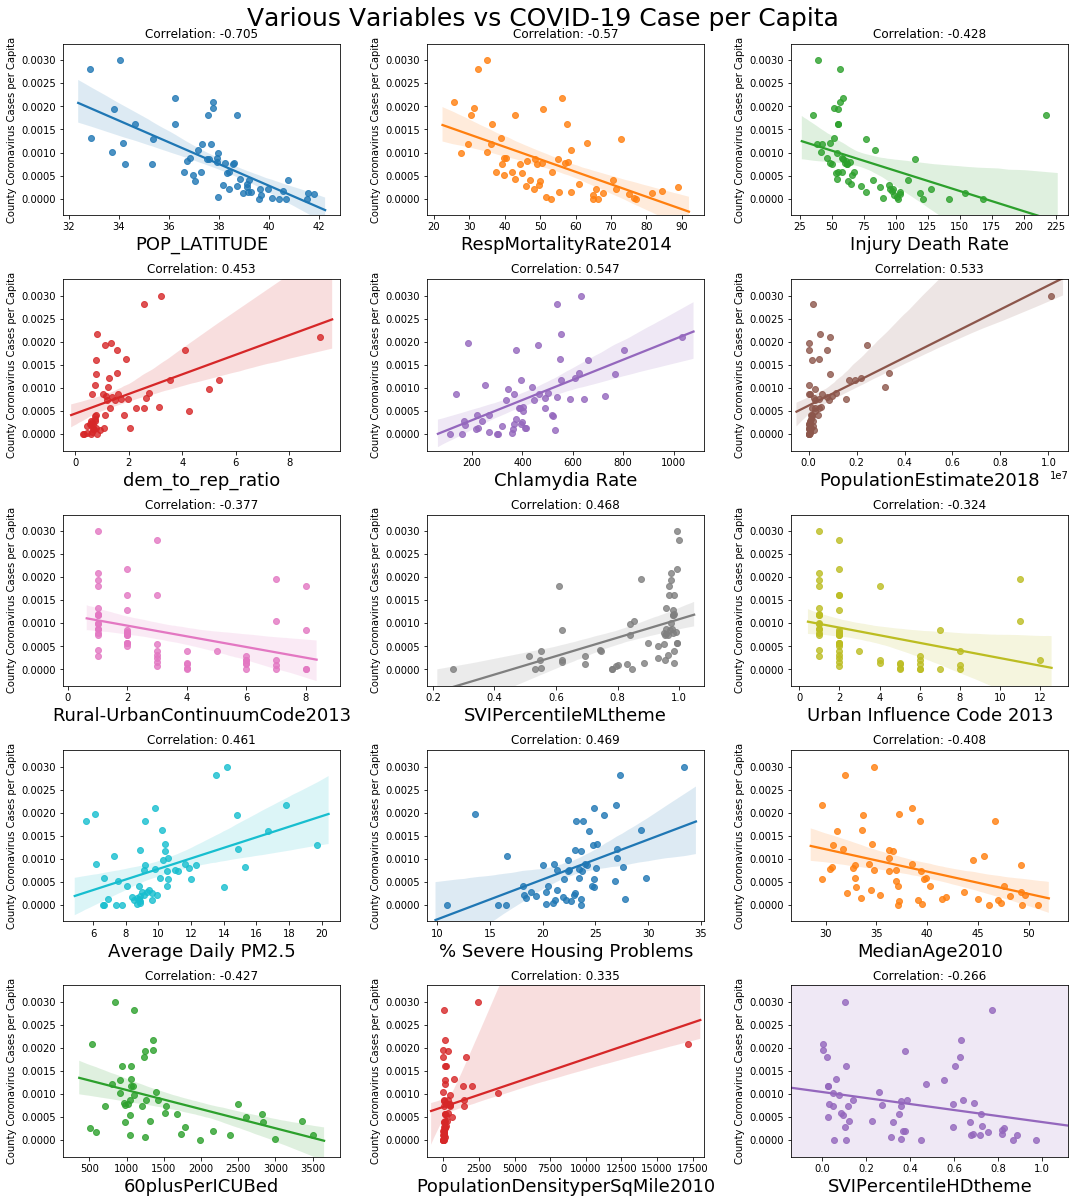

In [18]:
#Cases Correlations
cases_per_capita = california_cases['5/8/20']/california_cases['PopulationEstimate2018']
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_cases, cases_per_capita)
# Plot variables vs covid cases per capita. Each point is a county
plot_correlations(california_cases, corr, cases_per_capita, title="Various Variables vs COVID-19 Case per Capita")
# Plot log of variables vs covid deaths per capita. Each point is a county
plot_correlations(california_cases, log_normal_corr, cases_per_capita, title="Various Variables vs COVID-19 Case per Capita")

Same conclusions reached as the plots for deaths

### Cases doubling rate
Another useful metric is the number of days that it takes for number of cases (active cases for our calculations) to double. This is useful because the infections per day relies too heavily on how many infections there were a couple of days ago. For simplicity, we calculated active cases as the number of new cases from the past 14 days.

In [19]:
# Filter out the counties with a good number of cases already (if not, the doubling rate is likely not accurate or helpful)
hundred_plus_infections = california_cases[california_cases['5/12/20'] > 100]

# Find the infection rate, smoothed over by taking a moving average over the previous 5 days
dates = date_columns(hundred_plus_infections)
infections_rate_smoothed = hundred_plus_infections[dates].diff(axis=1).rolling(5, axis=1).mean()

# To find active cases, subtract each number of cases in each column from the number of cases from 14 columns (days) prior
new_cases_last_14_days = hundred_plus_infections[dates].iloc[:,14:] - hundred_plus_infections[dates].iloc[:,:-14].values

# To get doubling rate, divide active cases by the infection rate. We are only interested in the recent doubling rate
doubling_days = (new_cases_last_14_days/infections_rate_smoothed.iloc[:,14:]).iloc[:,-30:]
doubling_days.head(3)

4/14/20    4/15/20    4/16/20    4/17/20    4/18/20    4/19/20  \
0  13.434579  16.439394  16.119403  14.220183  14.845133  10.833333   
6  25.000000  17.596154  18.861386  15.642202  14.210526  10.886525   
9  12.803030  11.730769  12.364865  10.691489   9.590909  11.397849   

     4/20/20    4/21/20    4/22/20    4/23/20  ...     5/4/20     5/5/20  \
0  13.209607  12.970085  15.865922  14.243697  ...  14.014423  13.786408   
6  15.760870  13.008475  13.086957  16.823529  ...  14.117647  14.102564   
9  16.171875  13.197674  14.802632  12.175926  ...  16.736842  11.977612   

      5/6/20     5/7/20     5/8/20     5/9/20    5/10/20    5/11/20  \
0  13.678414  13.388626  13.160377  11.821862  11.647059  12.626050   
6  14.230769  17.615385  16.521739  12.977528  14.620253  18.095238   
9  12.530864  11.049383  10.277778   9.567308  10.023474  14.494048   

     5/12/20    5/13/20  
0  13.888889  14.055300  
6  16.716418  16.515152  
9  11.739130  13.040936  

[3 rows x 30 columns]

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


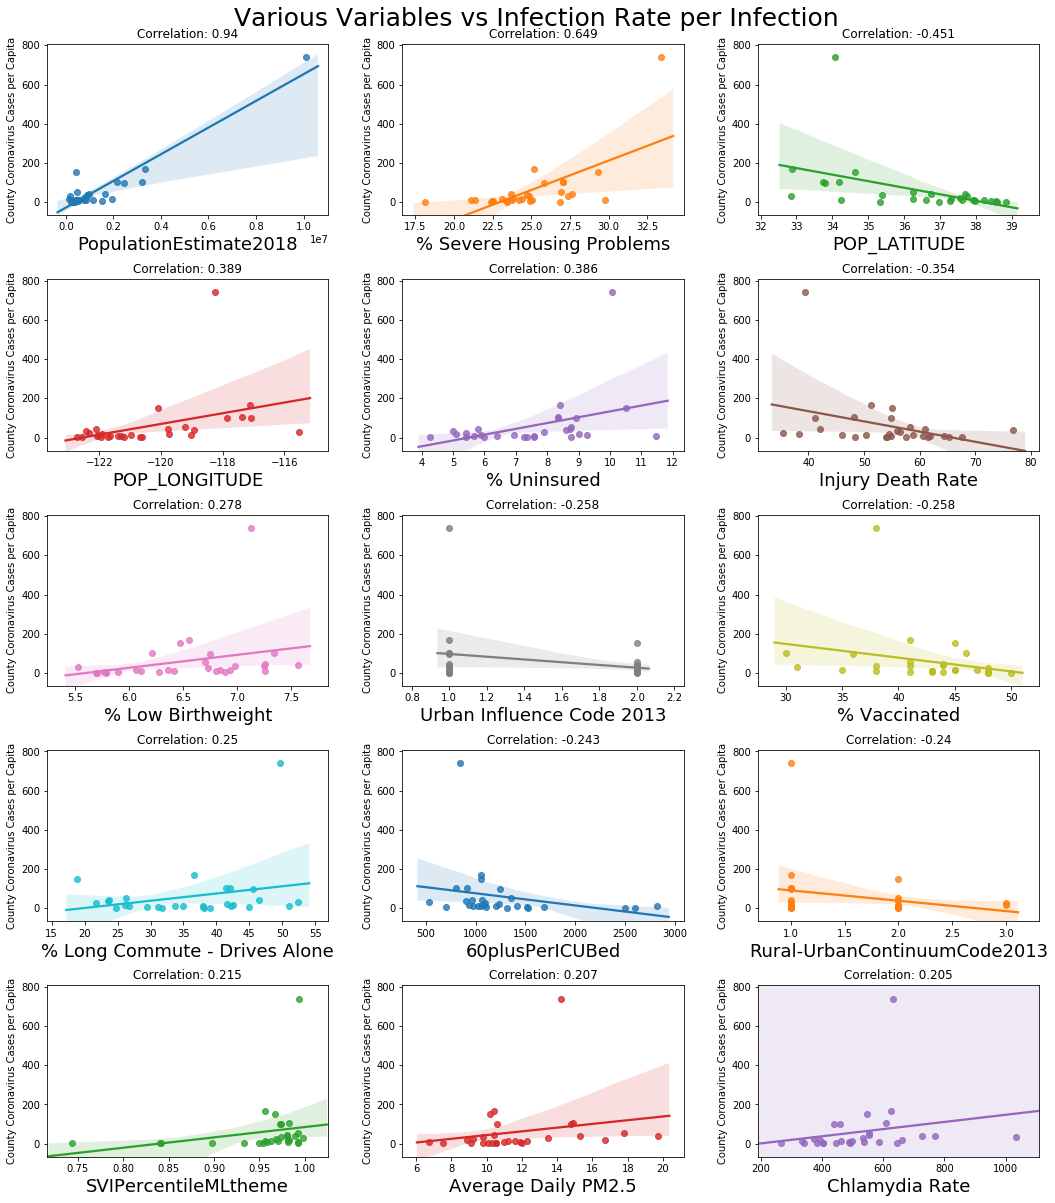

In [20]:
# Get current doubling rate
cases_doubling_rate  = infections_rate_smoothed['5/12/20']

# Find correlations between county demographics and doubling rate, plot.
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(hundred_plus_infections, cases_doubling_rate)
plot_correlations(hundred_plus_infections, corr, cases_doubling_rate, title="Various Variables vs Infection Rate per Infection")

The data seems to be tighter, because we filtered those who have worse outbreaks and thus are likely more similar in other respects. 

# PCA
Run PCA on just the cases for a CA. These methods can be easily replicated for any other state.

In [21]:
dates = date_columns(california_cases)

#take just the cases, and normalize by population
ca = california_cases[dates].div(california_cases['PopulationEstimate2018'], axis=0)
#center and standardize the variance
ca = ((ca - ca.mean())/np.std(ca)).drop(columns=['1/22/20', '1/23/20', '1/24/20', '1/25/20'])
#PCA!
u, s, vt = np.linalg.svd(ca, full_matrices=False)
#Put the first 10 PC into a dataframe
pc_df = pd.DataFrame((u @ np.diag(s))[:,:10], columns=['pc%d' % i for i in range(1, 11)])

#Calculate the percent variance that can be explained by the first PC1.
total_variance_computed_from_singular_values = np.sum(s**2)/ca.shape[0]
total_variance_computed_from_data = sum(np.var(ca, axis=0))
variance_explained_by_1st_pc = ((s[0]**2)/ca.shape[0])/total_variance_computed_from_data
variance_explained_by_1st_pc

0.4435062770382818

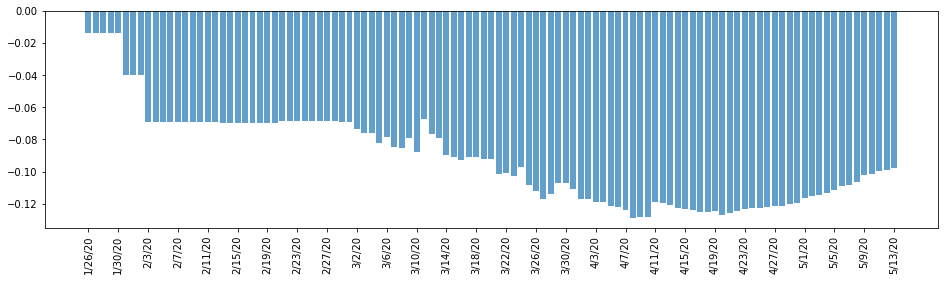

In [22]:
#See which dates most affect the first principal component
#Taken from HW8
def plot_pc(col_names, vt, k):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names[::4], rotation=90);
with plt.rc_context({"figure.figsize": (16, 4)}): 
    plot_pc(list(ca.columns), vt, 0);

### Plot the Counties by the largest two principal components
We can see that there is an outlier, San Benito, and there seems to be two distinct clusters, which we will explore later

In [23]:
fig = px.scatter(data_frame=pc_df, x='pc1', y='pc2', text=list(california_cases['County_x']))
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    title_text='pc1 vs pc2'
)

fig.show()

Here's the same plot, but with a third dimension: pc3!

In [24]:
fig = px.scatter_3d(data_frame=pc_df, x='pc1', y='pc2', z='pc3', text=list(california_cases['County_x']))
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    title_text='pc1 vs pc2 vs pc3'
)

fig.show()

Oddly enough, the counties with lower pc1 tend to have higher variation in pc3 values

Visually, we then isolated each cluster, and took the original cases time series data and plotted it to see the differences

In [25]:
temp = california_cases.copy()
#take only the cases by day and normalize based off of the population
temp = temp[dates].div(temp['PopulationEstimate2018'], axis=0)

#cluster0 is the outlier, San Benito, and from eye has pc2 less than 20
cluster0 = temp.iloc[pc_df[pc_df['pc2'] < -20].index]
#cluster1 is the cluster on the left
cluster1 = temp.iloc[pc_df[(pc_df['pc1'] < -10) & (pc_df['pc2'] > -20)].index]
#cluster2 is the group on the right
cluster2 = temp.iloc[pc_df[pc_df['pc1'] > -10].index]

The below plot is the beginning of the spread in California, with each county a line, colored by cluster, the first 40 days after 1/23/20. As we can see, the outlier is San Benito in blue, which had a massive per capita spike in infections (or testing).

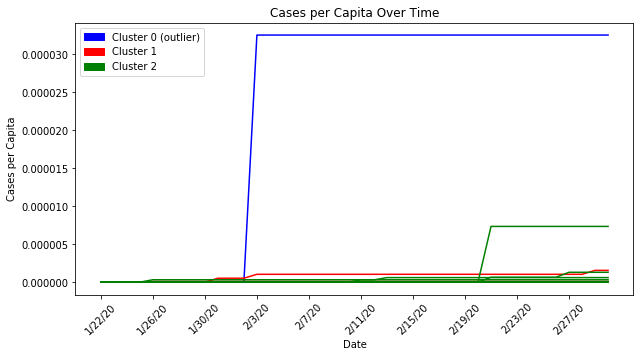

In [26]:
red_patch = mpatches.Patch(color='red', label='Cluster 1')
blue_patch = mpatches.Patch(color='blue', label='Cluster 0 (outlier)')
green_patch = mpatches.Patch(color='green', label='Cluster 2')

plt.figure(figsize=(10,5))
plt.plot(cluster0.T.drop(cluster1.columns.values[40:]), color='blue', label='cluster0')
plt.plot(cluster1.T.drop(cluster1.columns.values[40:]), color='red', label='cluster1')
plt.plot(cluster2.T.drop(cluster1.columns.values[40:]), color='green', label='cluster2')
plt.title('Cases per Capita Over Time')
plt.xlabel('Date')
plt.ylabel('Cases per Capita')
plt.xticks(cluster1.columns.values[:40:4], rotation=45)
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()

We then plot the rest of the days

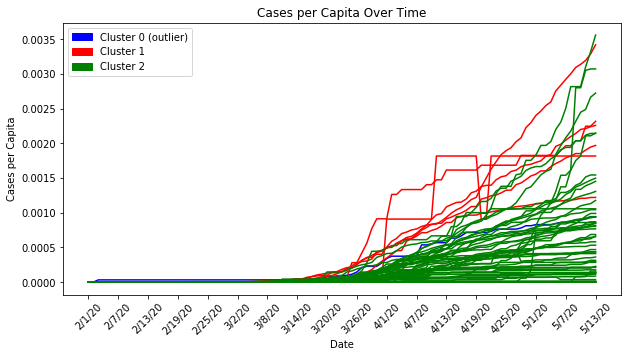

In [27]:
plt.figure(figsize=(10,5))
red_patch = mpatches.Patch(color='red', label='Cluster 1')
blue_patch = mpatches.Patch(color='blue', label='Cluster 0 (outlier)')
green_patch = mpatches.Patch(color='green', label='Cluster 2')
plt.plot(cluster0.T.drop(cluster1.columns.values[:10]), color='blue')
plt.plot(cluster1.T.drop(cluster1.columns.values[:10]), color='red')
plt.plot(cluster2.T.drop(cluster1.columns.values[:10]), color='green')
plt.title('Cases per Capita Over Time')
plt.xlabel('Date')
plt.ylabel('Cases per Capita')
plt.xticks(cluster1.columns.values[10::6], rotation=45)
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()

It's clear that the red cluster, with smaller pc1 and higher pc2, tends to be more hard hit by the pandemic (especially in the middle). 

# SVI Exploration

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


pd.options.display.max_seq_items = None

Let's take a quick look at our data, especially CA's counties

In [29]:
counties = pd.read_csv('covid19/small_abridged.csv')

cases = pd.read_csv('county_info_cases_deaths.csv')
county_unique_columns = []
for i in counties.columns:
    if i not in cases.columns:
        county_unique_columns += [i]
county_unique_columns += ['CountyName']
cases_info = cases.merge(counties[county_unique_columns], how='left', on='CountyName')
ca = cases_info.loc[cases_info['StateName'] == 'CA']
ca

Unnamed: 0  countyFIPS  STATEFP  COUNTYFP CountyName StateName  \
1034         180        6001      6.0       1.0    Alameda        CA   
1035         181        6003      6.0       3.0     Alpine        CA   
1036         182        6005      6.0       5.0     Amador        CA   
1037         183        6007      6.0       7.0      Butte        CA   
1038         183        6007      6.0       7.0      Butte        CA   
...          ...         ...      ...       ...        ...       ...   
1114         233        6107      6.0     107.0     Tulare        CA   
1115         234        6109      6.0     109.0   Tuolumne        CA   
1116         235        6111      6.0     111.0    Ventura        CA   
1117         236        6113      6.0     113.0       Yolo        CA   
1118         237        6115      6.0     115.0       Yuba        CA   

           State        lat         lon  POP_LATITUDE  ...  Chlamydia Rate  \
1034  California  37.646537 -121.849494     37.705201  ...           553.2   
1035  California  38.595405 -119.817665     38.728298  ...           803.6   
1036  California  38.452565 -120.640865     38.394208  ...           170.9   
1037  California  39.667234 -121.600771     39.669037  ...           527.3   
1038  California  39.667234 -121.600771     39.669037  ...           153.7   
...          ...        ...         ...           ...  ...             ...   
1114  California  36.218127 -118.791993     36.251227  ...           554.2   
1115  California  38.028841 -119.955589     37.971531  ...           267.3   
1116  California  34.490146 -119.071524     34.241989  ...           333.3   
1117  California  38.691680 -121.904841     38.598913  ...           491.1   
1118  California  39.265110 -121.352660     39.138830  ...           398.5   

     Teen Birth Rate Preventable Hospitalization Rate  % Vaccinated  \
1034       11.408149                           3298.0          44.0   
1035             NaN                           2480.0          21.0   
1036       18.101093                           3115.0          46.0   
1037       17.643410                           4656.0          39.0   
1038             NaN                           2548.0          27.0   
...              ...                              ...           ...   
1114       37.738078                           4469.0          41.0   
1115       16.505726                           2464.0          45.0   
1116       17.919179                           3359.0          45.0   
1117        9.352084                           2878.0          50.0   
1118       30.804981                           4921.0          40.0   

      Violent Crime Rate  Injury Death Rate  Average Daily PM2.5  \
1034          628.781962          42.021286                 10.4   
1035          442.477876         217.470098                  5.6   
1036          237.070738          97.813731                  8.9   
1037          327.057309          98.235283                  8.9   
1038          138.861337          93.479785                  5.8   
...                  ...                ...                  ...   
1114          381.807643          58.254059                 17.8   
1115          316.156731         101.062077                  8.9   
1116          240.489673          50.286454                 11.2   
1117          331.889440          48.423135                  9.8   
1118          413.727115          87.380050                  9.6   

      Presence of Water Violation  % Drive Alone to Work  \
1034                          0.0              61.489237   
1035                          0.0              66.011236   
1036                          0.0              80.634378   
1037                          1.0              75.287737   
1038                          0.0              76.373057   
...                           ...                    ...   
1114                          1.0              78.130283   
1115                          1.0              81.3623

For our project, we are examining the relationship between a county's SVI score and COVID-19's impact on that county, in terms of case rate and death rate. First we'll examine cases and SVI as a percentile.

In [30]:
cases_columns, death_columns = [], []
for i in cases_info.columns:
    if 'cases' in i:
        cases_columns += [i]
    elif 'death' in i:
        death_columns += [i]
cases_only = cases_info[cases_columns].copy()
cases_only['StateName'] = cases_info['State'].copy()
cases_only['pop'] = cases_info['PopulationEstimate2018'].copy()
cases_only['mean_svi'] = cases_info['SVIPercentile'].copy()
ca_cases_only = cases_only.loc[cases_only['StateName'] == 'California']

deaths_only = cases_info[death_columns].copy()
deaths_only['StateName'] = cases_info['State'].copy()
deaths_only['pop'] = cases_info['PopulationEstimate2018'].copy()
deaths_only['mean_svi'] = cases_info['SVIPercentile'].copy()
ca_deaths_only = deaths_only.loc[deaths_only['StateName'] == 'California']

def plot_svi_bins(df=cases_only, num_bins=4, cases=True, state='California', nation=False):
    bins = list(np.arange(0,  1+(1/num_bins), 1/num_bins))
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    for i in range(num_bins):
        binned = df.loc[df['mean_svi'] > bins[i]]
        binned = df.loc[df['mean_svi'] < bins[i+1]]
        if not nation:
            binned = binned.loc[binned['StateName'] == state]
        binned = binned.drop('StateName', axis=1)
        binned = binned.sum(axis=0)[:-1]
        binned = binned / binned['pop']
        binned = binned[:-1]
        if cases:
            binned.index = pd.to_datetime(binned.index.str.replace('_cases', ''))
        else:
            binned.index = pd.to_datetime(binned.index.str.replace('_deaths', ''))
        sns.lineplot(x = binned.index, y = binned.values, ax=ax, label = str(bins[i]) + '-' + str(bins[i+1]))
    plt.xlabel('Time')
    if cases:
        plt.ylabel('Case Rate (per person)')
        plt.title('Case Rate Over Time')
    else:
        plt.ylabel('Death Rate (per person)')
        plt.title('Death Rate Over Time')
    plt.setp(ax.get_xticklabels(), rotation=60)
    ax.legend()
    plt.legend(title = "SVI Percentile")
    plt.show()

The cell above defines a function that will plot the case curve over time, binned into quartiles. The bins and state can be changed. Feel free to fiddle and explore!

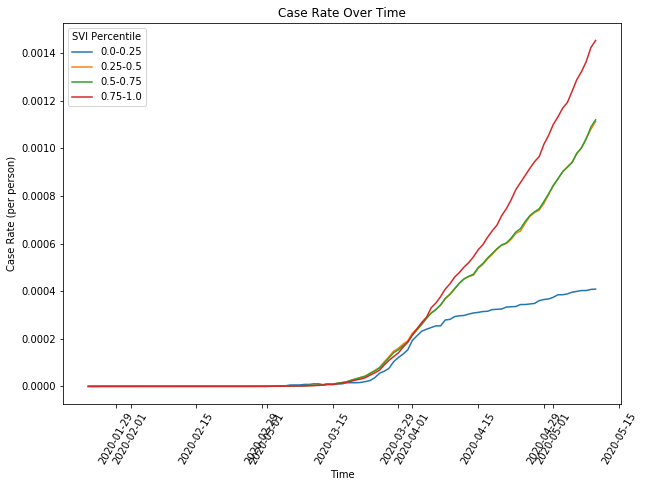

In [31]:
plot_svi_bins()

Unsurprisingly, we see that counties with the highest social vulnerability have the steepest cases curve. There is a surprising flat plateau to the counties with the lowest social vulnerability. The following cell shows the death rates.

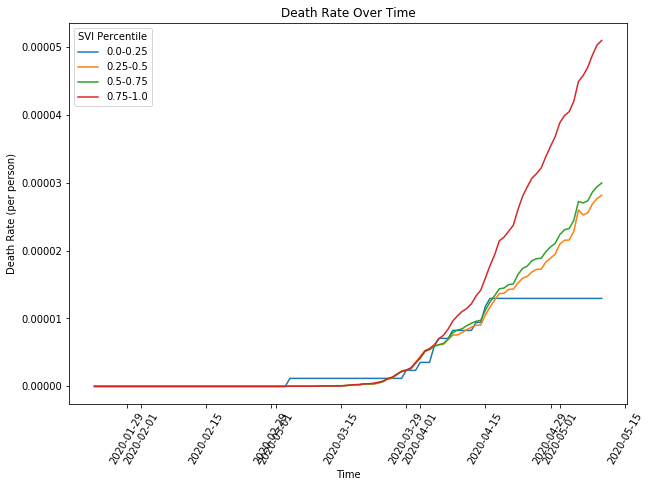

In [32]:
plot_svi_bins(df=deaths_only, cases=False)

Once again we see that the least vulnerable counties, understandably, have had the smallest impact from covid. An interesting feature is the flatline starting in the middle of may for the least vulnerable counties.
Now we'll examine which factors of SVI have the largest impact on COVID's case and death rate among counties.

In [33]:
ca_cases_only = ca_cases_only.drop('mean_svi', axis=1)

In [34]:
svi_columns = ['SVIPercentileSEtheme', 'SVIPercentileHDtheme', 
                  'SVIPercentileMLtheme', 'SVIPercentileHTtheme']
svi_df = ca[svi_columns]
svi_columns

corr = []
log_log_corr = []


#print(ca_cases_only.sum(axis=0))
max_cases = ca_cases_only['5/9/20_cases']
max_cases = max_cases / ca['PopulationEstimate2018']
max_cases_logged = np.log(max_cases)
for col in svi_columns:
    column = svi_df[col]
    corr.append((col, column.corr(max_cases)))
    log_log_corr.append((col, np.log(column).corr(max_cases_logged)))
    


/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



The correlation nbetween each theme and covid is not particularly strong, with the strongest appearing to be the Minority and Language theme. Interesting to note is the negative correlation between Housing and Disability. One possible explanation: communities with a higher percentage of the population disabled are less able to leave the house and less likely to spread the virus.

In [35]:
print('Correlation with cases from 5/9/20',) 
print(sorted([x for x in corr if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:10])

Correlation with cases from 5/9/20
[('SVIPercentileMLtheme', 0.4055770619689305), ('SVIPercentileHTtheme', 0.29336887592386984), ('SVIPercentileHDtheme', -0.2728952746910521), ('SVIPercentileSEtheme', 0.01399698309365731)]


In [36]:
ca_deaths_only = ca_deaths_only.drop('mean_svi', axis=1)

In the below cell, we will see the same correlations but for deaths.

In [37]:
corr = []
log_log_corr = []


max_deaths = ca_deaths_only['5/9/20_deaths']
max_deaths = ca['PopulationEstimate2018']
max_deaths_logged = np.log(max_deaths)
for col in svi_columns:
    column = svi_df[col]
    corr.append((col, column.corr(max_deaths)))
    log_log_corr.append((col, np.log(column).corr(max_deaths_logged)))
    

print('Correlation with deaths from 5/9/20') 
print(sorted([x for x in corr if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:10])
print('\nLog Correlation with deaths from 5/9/20')
print(sorted([x for x in log_log_corr if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:10])

Correlation with deaths from 5/9/20
[('SVIPercentileHDtheme', -0.19286789463424173), ('SVIPercentileHTtheme', 0.15511723672169334), ('SVIPercentileSEtheme', -0.11144153316641105), ('SVIPercentileMLtheme', 0.10828420515898192)]

Log Correlation with deaths from 5/9/20
[('SVIPercentileHTtheme', 0.24896059680691723), ('SVIPercentileHDtheme', -0.2358317277845422), ('SVIPercentileSEtheme', -0.10659019356685093), ('SVIPercentileMLtheme', 0.06848370440051986)]


Recall:
<li><b>Socioeconomic Theme</b>: the county's percentile ranking from the SVI socioeconomic theme, which accounts for poverty level, unemployment, income, high school diploma.</li>
<li><b>Housing Composition & Disability</b>: the county's percentile ranking from the SVI housing composition and disability theme, which accounts for composition of those $\geq$ 65, $\leq$ 17, >5 with a disability, and single-parent households.</li>
<li><b>Minority status and language</b>: the county's percentile ranking from the SVI minority status and language theme, which accounts for minority status and if one speaks English "less than well"</li>
<li><b>Housing & Transportation</b>: the county's percentile ranking from the SVI housing and transportation theme, which accounts for multi-unit structures, mobile homes, crowding, no vehicles, and group quarters</li>


All these correlations seem to be fairly low, with the SE theme seemingly uncorrelated with the virus impact. The numbers are still somewhat informative, and seem to imply the HD theme as being the most correlated with covid impact (both in cases and deaths). The correlation is negative, however, which is surprising. One possible explanation for this negative correlation is that fewer people in disabled households get tested, resulting in fewer relative cases and deaths compared to people in able households. The housing and trasportation theme, which we originally predicted to have the greatest correlation on COVID19 cases and deaths, does in fact have the largest positive correlation. People living in multi-unit structures and mobile homes are more suceptible to COVID19, and people forced to use public transit are also more suceptible to COVID19 than those who have their own vehicles

Does the SVI theme that affects COVID the most change over time? For example, could social distancing measures make one theme more (or less) important?

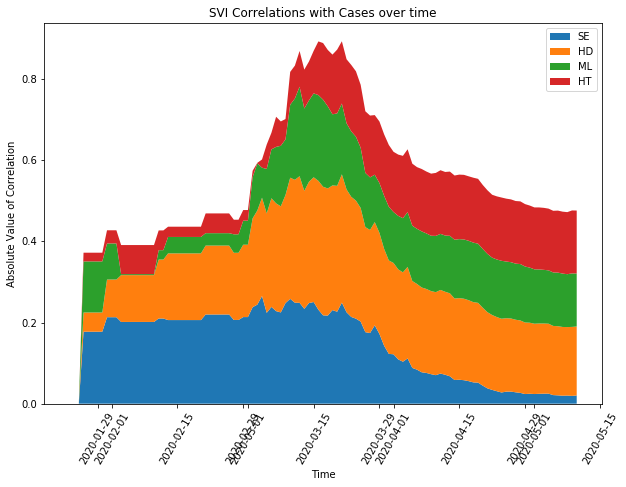

In [38]:
case_matrix = ca_cases_only.iloc[:,:-2]
x = pd.to_datetime(case_matrix.columns.str.replace('_cases', ''))

y = np.ndarray(shape=(4, x.size))

for i in range(4):
    y[i] = case_matrix.apply(lambda x: x.corr(svi_df[svi_columns[i]]))
fig = plt.figure(figsize=(10, 7))
y = np.nan_to_num(y)
y = np.abs(y)
p = plt.stackplot(x, y, labels = ['SE', 'HD', 'ML', 'HT'])
plt.xlabel('Time')
plt.ylabel('Absolute Value of Correlation')
plt.legend()
plt.xticks(rotation=60)
plt.title('SVI Correlations with Cases over time')
plt.show()

With deaths:

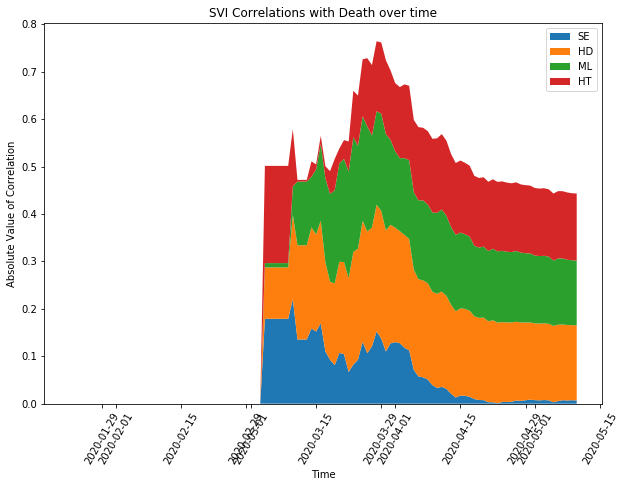

In [39]:
death_matrix = ca_deaths_only.iloc[:,:-2]
death_x = pd.to_datetime(death_matrix.columns.str.replace('_deaths', ''))

death_y = np.ndarray(shape=(4, death_x.size))


def get_svi_corr(columm):
    return column.corr(svi_df['SVIPercentileSEtheme'])
for i in range(4):
    death_y[i] = death_matrix.apply(lambda x: x.corr(svi_df[svi_columns[i]]))
fig = plt.figure(figsize=(10, 7))
death_y = np.nan_to_num(death_y)
death_y = np.abs(death_y)
p = plt.stackplot(death_x, death_y, labels = ['SE', 'HD', 'ML', 'HT'])
plt.xlabel('Time')
plt.ylabel('Absolute Value of Correlation')
plt.legend()
plt.xticks(rotation=60)
plt.title('SVI Correlations with Death over time')
plt.show()

Here we can see the same graphs normalized, so the sum of each day's correlation sums to 1.

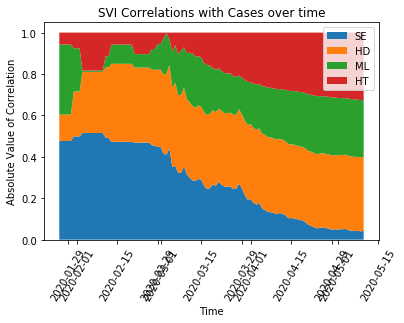

In [40]:
y_df = pd.DataFrame(y)
y_df = y_df / y_df.sum(axis=0)

p = plt.stackplot(x, y_df, labels = ['SE', 'HD', 'ML', 'HT'])
plt.xlabel('Time')
plt.ylabel('Absolute Value of Correlation')
plt.legend()
plt.xticks(rotation=60)
plt.title('SVI Correlations with Cases over time')
plt.show()

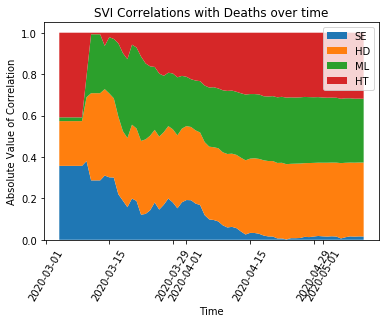

In [41]:
death_y_df = pd.DataFrame(death_y)
death_y_df = death_y_df / death_y_df.sum(axis=0)

p = plt.stackplot(death_x, death_y_df, labels = ['SE', 'HD', 'ML', 'HT'])
plt.xlabel('Time')
plt.ylabel('Absolute Value of Correlation')
plt.legend()
plt.xticks(rotation=60)
plt.title('SVI Correlations with Deaths over time')
plt.show()

We can similarly generalize this for any state. The corr_stack_plot() function will create a stackplot relating the correlations of each SVI theme for a state over time.

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in true_divide



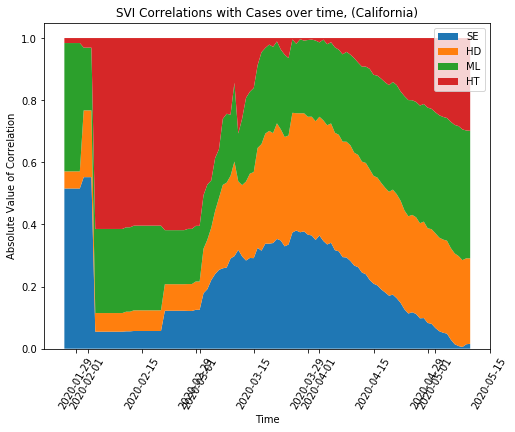

In [42]:
def corr_stack_plot(df=cases_info, cases=True, state='California', nation=False, normalized=True):
    svi_df = df[svi_columns + ['State']]
    if cases:
        columns = cases_columns + ['PopulationEstimate2018', 'State']
        df = df[columns].copy()
    else:
        columns = death_columns + ['PopulationEstimate2018', 'State']
        df = df[death_columns].copy()
    if not nation:
        df = df.loc[df['State'] == state]
        svi_df = svi_df.loc[svi_df['State'] == state]
        df = df.drop('State', axis=1)
        svi_df = svi_df.drop('State', axis=1)
    df = df.divide(df['PopulationEstimate2018'], axis=0)
    df = df.drop('PopulationEstimate2018', axis=1)
    if cases:
        x = pd.to_datetime(df.columns.str.replace('_cases', ''))
    else:
        x = pd.to_datetime(df.columns.str.replace('_deaths', ''))
    fig = plt.figure(figsize=(8, 6))
    y = np.ndarray(shape=(4, x.size))
    for i in range(4):
        y[i] = df.apply(lambda x: x.corr(svi_df[svi_columns[i]]))
    y = np.nan_to_num(y)
    y = np.abs(y)
    if normalized:
        y = y / y.sum(axis=0)
    p = plt.stackplot(x, y, labels = ['SE', 'HD', 'ML', 'HT'])
    
    plt.xlabel('Time')
    if cases:
        title = 'SVI Correlations with Cases over time'
        if nation:
            title += ', (nationwide)'
        else:
            title += ', (' + state +')'
    else:
        plt.title('SVI Correlations with Deaths over time')
        if nation:
            title += ', (nationwide)'
        else:
            title += ', (' + state +')'
    plt.title(title)
    plt.ylabel('Absolute Value of Correlation')
    plt.legend()
    plt.xticks(rotation=60)
    plt.show()

corr_stack_plot()

We can do a similar binned analysis for the nation, not just California or any particular state.

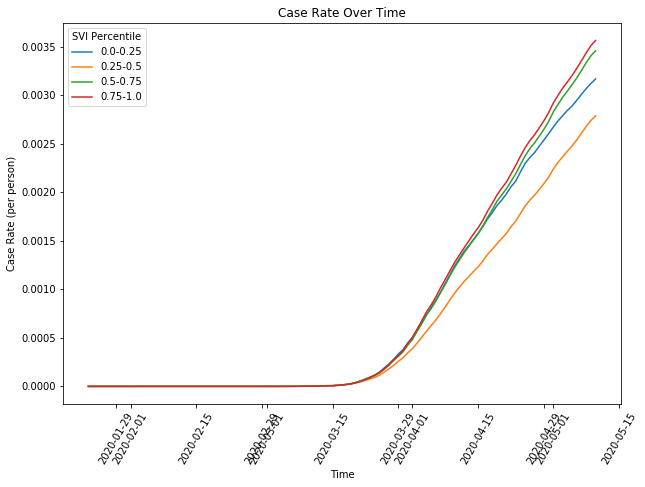

In [43]:
plot_svi_bins(nation=True)

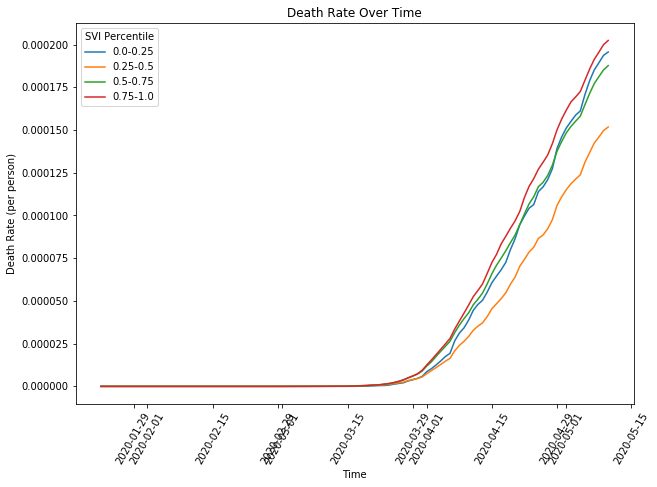

In [44]:
plot_svi_bins(df=deaths_only, cases=False, nation=True)

In [45]:
# % load_ext autoreload

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import plotly.express as px

In [46]:
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',
           error_bad_lines=False)
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
                   error_bad_lines=False)
#cases['FIPS'] = cases['FIPS'].astype('int')
day_cases = get_day_cases()
counties = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv',
                      error_bad_lines=False)
county_cases = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_level/processed/nytimes_infections/nytimes_infections.csv',
                          error_bad_lines=False)

death_keep = [col+'_deaths' if (col in cases.columns and col != 'FIPS') else col for col in deaths.columns]
cases_keep = [col+'_cases' for col in cases.columns[12:]]
cases_and_deaths = cases.merge(deaths, on='FIPS', suffixes=('_cases', '_deaths'))[death_keep+cases_keep]
renamer = lambda name: name if (type(name) != str or '/' in name or '_deaths' not in name) else name[:-7]
cases_and_deaths = cases_and_deaths.rename(columns=renamer)
cases_and_deaths.head()

valid_territories = cases_and_deaths[(cases_and_deaths['Lat'] > 0) & ~np.isnan(cases_and_deaths['FIPS'])]
valid_territories.loc[:, 'FIPS'] = valid_territories['FIPS'].astype('int')
valid_counties = counties[~counties['countyFIPS'].isin(['City1', 'City2'])]
valid_counties.loc[:, 'countyFIPS'] = valid_counties['countyFIPS'].astype('int')

county_all = valid_counties.merge(valid_territories, left_on='countyFIPS', right_on='FIPS')
county_all = county_all.drop(columns=['Lat', 'Long_', 'Province_State', 'Country_Region', 'FIPS'])

/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
day_cases[0].columns

Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3',
       'Testing_Rate', 'Hospitalization_Rate'],
      dtype='object')

In [48]:
get_trait_ts = lambda terr, trait: [day_cases[day][trait][terr] for day in range(len(day_cases))]

def moving_average(a, n=4, ndim=1) :
    """
    From https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    """
    if ndim == 2:
        return moving_average_2d(a, n=n)
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_average_2d(a, n=7):
    ret = np.cumsum(a, axis=1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

def featurize(dfs, features, n=4, target=30, day_buffer=5):
    """
    Given a list of column names, return a design matrix in the form a NumPy array.
    Note: time-series features are flattened so that we don't have to deal with tensor multiplication :)
    """
    num_per = min((target - day_buffer), len(dfs) - n + 1)
    design_matrix = np.zeros((50, (len(features))*num_per))
    for i in range(len(features)):
        for terr in range(50):
            avged_ts = moving_average(get_trait_ts(terr, features[i]), n=n)
            avged_ts = avged_ts[:target-day_buffer]
            design_matrix[terr, num_per*i:num_per*(i+1)] = avged_ts
    return design_matrix

def get_targets(dfs, feature, day, n=4):
    return np.array([moving_average(get_trait_ts(terr, feature), n=n)[day-n+1] for terr in range(50)])

def preprocess(dfs, features, n=4, day_buffer=5):
    design_matrix = featurize(dfs, features, n=n, day_buffer=day_buffer)
    return design_matrix

In [49]:
cd = preprocess(day_cases, ['Confirmed', 'Deaths', 'Recovered', 'People_Tested'], n=4, day_buffer=0)
goals = get_targets(day_cases, 'Mortality_Rate', 30)

In [50]:
cd.shape

(50, 112)

In [51]:
lr = LinearRegression(fit_intercept=True)
scores = cross_val_score(lr, cd, goals, cv=5, scoring='r2')

In [52]:
scores

array([-317.77074007,  -19.73553   ,   -4.81334683, -169.59467641,
        -24.55009569])

In [53]:
day_cases[1]

Province_State Country_Region          Last_Update      Lat     Long_  \
0          Alabama             US  2020-04-13 23:07:54  32.3182  -86.9023   
1           Alaska             US  2020-04-13 23:07:54  61.3707 -152.4044   
2          Arizona             US  2020-04-13 23:07:54  33.7298 -111.4312   
3         Arkansas             US  2020-04-13 23:07:54  34.9697  -92.3731   
4       California             US  2020-04-13 23:07:54  36.1162 -119.6816   
5         Colorado             US  2020-04-13 23:07:54  39.0598 -105.3111   
6      Connecticut             US  2020-04-13 23:07:54  41.5978  -72.7554   
7         Delaware             US  2020-04-13 23:07:54  39.3185  -75.5071   
8          Florida             US  2020-04-14 00:42:00  27.7663  -81.6868   
9          Georgia             US  2020-04-13 23:07:54  33.0406  -83.6431   
10          Hawaii             US  2020-04-13 23:07:54  21.0943 -157.4983   
11           Idaho             US  2020-04-13 23:07:54  44.2405 -114.4788   
12        Illinois             US  2020-04-13 23:07:54  40.3495  -88.9861   
13         Indiana             US  2020-04-13 23:07:54  39.8494  -86.2583   
14            Iowa             US  2020-04-13 23:07:54  42.0115  -93.2105   
15          Kansas             US  2020-04-13 23:07:54  38.5266  -96.7265   
16        Kentucky             US  2020-04-13 23:07:54  37.6681  -84.6701   
17       Louisiana             US  2020-04-13 23:07:54  31.1695  -91.8678   
18           Maine             US  2020-04-13 23:07:54  44.6939  -69.3819   
19        Maryland             US  2020-04-13 23:07:54  39.0639  -76.8021   
20   Massachusetts             US  2020-04-13 23:07:54  42.2302  -71.5301   
21        Michigan             US  2020-04-13 23:07:54  43.3266  -84.5361   
22       Minnesota             US  2020-04-13 23:07:54  45.6945  -93.9002   
23     Mississippi             US  2020-04-13 23:07:54  32.7416  -89.6787   
24        Missouri             US  2020-04-13 23:07:54  38.4561  -92.2884   
25         Montana             US  2020-04-13 23:07:54  46.9219 -110.4544   
26        Nebraska             US  2020-04-13 23:07:54  41.1254  -98.2681   
27          Nevada             US  2020-04-13 23:07:54  38.3135 -117.0554   
28   New Hampshire             US  2020-04-13 23:07:54  43.4525  -71.5639   
29      New Jersey             US  2020-04-13 23:07:54  40.2989  -74.5210   
30      New Mexico             US  2020-04-13 23:07:54  34.8405 -106.2485   
31        New York             US  2020-04-13 23:07:54  42.1657  -74.9481   
32  North Carolina             US  2020-04-13 23:07:54  35.6301  -79.8064   
33    North Dakota             US  2020-04-13 23:07:54  47.5289  -99.7840   
34            Ohio             US  2020-04-13 23:07:54  40.3888  -82.7649   
35        Oklahoma             US  2020-04-13 23:07:54  35.5653  -96.9289   
36          Oregon             US  2020-04-13 23:07:54  44.5720 -122.0709   
37    Pennsylvania             US  2020-04-13 23:07:54  40.5908  -77.2098   
38    Rhode Island             US  2020-04-13 23:07:54  41.6809  -71.5118   
39  South Carolina             US  2020-04-13 23:07:54  33.8569  -80.9450   
40    South Dakota             US  2020-04-13 23:07:54  44.2998  -99.4388   
41       Tennessee             US  2020-04-13 23:07:54  35.7478  -86.6923   
42           Texas             US  2020-04-13 23:07:54  31.0545  -97.5635   
43            Utah             US  2020-04-13 23:07:54  40.1500 -111.8624   
44         Vermont             US  2020-04-13 23:07:54  44.0459  -72.7107   
45        Virginia             US  2020-04-13 23:07:54  37.7693  -78.1700   
46      Washington             US  2020-04-13 23:07:54  47.4009 -121.4905   
47   West Virginia             US  2020-04-13 23:07:54  38.4912  -80.9545   
48       Wisconsin             US  2020-04-13 23:07:54  44.2685  -89.6165   
49         Wyoming             US  2020-04-13 23:07:54  42.7560 -107.3025   

    Confirmed  Deaths  Recovered    Active  FIPS  Incident_Rate  \
0      36

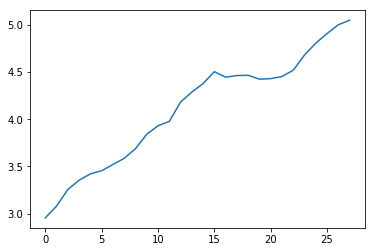

In [54]:
plt.plot(moving_average(mort_rates[24]))

In [55]:
get_trait_ts(2, 'Mortality_Rate')

[3.246753247,
 3.292847503373819,
 3.439222893,
 3.5822401614530777,
 3.5402407363700727,
 3.746397694524496,
 3.8103302286198137,
 3.729981755524022,
 3.768745067087608,
 3.9573820395738197,
 4.220719897679517,
 4.3139293139293144,
 4.400330851943755,
 4.342984409799555,
 4.2087542087542085,
 4.089219330855019,
 3.9539899352983454,
 4.2724372312387295,
 4.18027433050294,
 4.141046555402183,
 3.9454806312769013,
 4.189814814814815,
 4.056476916181085,
 4.2450295540032235,
 4.38858555681467,
 4.524886877828054,
 4.911647349420481,
 4.854014598540147,
 4.820577390053061,
 4.761486427128173,
 4.788684389911384]

In [56]:
day_cases[0]

Province_State Country_Region          Last_Update      Lat     Long_  \
0          Alabama             US  2020-04-12 23:18:15  32.3182  -86.9023   
1           Alaska             US  2020-04-12 23:18:15  61.3707 -152.4044   
2          Arizona             US  2020-04-12 23:18:15  33.7298 -111.4312   
3         Arkansas             US  2020-04-12 23:18:15  34.9697  -92.3731   
4       California             US  2020-04-12 23:18:15  36.1162 -119.6816   
5         Colorado             US  2020-04-12 23:18:15  39.0598 -105.3111   
6      Connecticut             US  2020-04-12 23:18:15  41.5978  -72.7554   
7         Delaware             US  2020-04-12 23:18:15  39.3185  -75.5071   
8          Florida             US  2020-04-12 23:18:15  27.7663  -81.6868   
9          Georgia             US  2020-04-12 23:18:15  33.0406  -83.6431   
10          Hawaii             US  2020-04-12 23:18:15  21.0943 -157.4983   
11           Idaho             US  2020-04-12 23:18:15  44.2405 -114.4788   
12        Illinois             US  2020-04-12 23:18:15  40.3495  -88.9861   
13         Indiana             US  2020-04-12 23:18:15  39.8494  -86.2583   
14            Iowa             US  2020-04-12 23:18:15  42.0115  -93.2105   
15          Kansas             US  2020-04-12 23:18:15  38.5266  -96.7265   
16        Kentucky             US  2020-04-12 23:18:15  37.6681  -84.6701   
17       Louisiana             US  2020-04-12 23:18:15  31.1695  -91.8678   
18           Maine             US  2020-04-12 23:18:15  44.6939  -69.3819   
19        Maryland             US  2020-04-12 23:18:15  39.0639  -76.8021   
20   Massachusetts             US  2020-04-12 23:18:15  42.2302  -71.5301   
21        Michigan             US  2020-04-12 23:18:15  43.3266  -84.5361   
22       Minnesota             US  2020-04-12 23:18:15  45.6945  -93.9002   
23     Mississippi             US  2020-04-12 23:18:15  32.7416  -89.6787   
24        Missouri             US  2020-04-12 23:18:15  38.4561  -92.2884   
25         Montana             US  2020-04-12 23:18:15  46.9219 -110.4544   
26        Nebraska             US  2020-04-12 23:18:15  41.1254  -98.2681   
27          Nevada             US  2020-04-12 23:18:15  38.3135 -117.0554   
28   New Hampshire             US  2020-04-12 23:18:15  43.4525  -71.5639   
29      New Jersey             US  2020-04-12 23:18:15  40.2989  -74.5210   
30      New Mexico             US  2020-04-12 23:18:15  34.8405 -106.2485   
31        New York             US  2020-04-12 23:18:15  42.1657  -74.9481   
32  North Carolina             US  2020-04-12 23:18:15  35.6301  -79.8064   
33    North Dakota             US  2020-04-12 23:18:15  47.5289  -99.7840   
34            Ohio             US  2020-04-12 23:18:15  40.3888  -82.7649   
35        Oklahoma             US  2020-04-12 23:18:15  35.5653  -96.9289   
36          Oregon             US  2020-04-12 23:18:15  44.5720 -122.0709   
37    Pennsylvania             US  2020-04-12 23:18:15  40.5908  -77.2098   
38    Rhode Island             US  2020-04-12 23:18:15  41.6809  -71.5118   
39  South Carolina             US  2020-04-12 23:18:15  33.8569  -80.9450   
40    South Dakota             US  2020-04-12 23:18:15  44.2998  -99.4388   
41       Tennessee             US  2020-04-12 23:18:15  35.7478  -86.6923   
42           Texas             US  2020-04-12 23:18:15  31.0545  -97.5635   
43            Utah             US  2020-04-12 23:18:15  40.1500 -111.8624   
44         Vermont             US  2020-04-12 23:18:15  44.0459  -72.7107   
45        Virginia             US  2020-04-12 23:18:15  37.7693  -78.1700   
46      Washington             US  2020-04-12 23:18:15  47.4009 -121.4905   
47   West Virginia             US  2020-04-12 23:18:15  38.4912  -80.9545   
48       Wisconsin             US  2020-04-12 23:18:15  44.2685  -89.6165   
49         Wyoming             US  2020-04-12 23:18:15  42.7560 -107.3025   

    Confirmed  Deaths  Recovered  Active  FIPS  Incident_Rate  People_Tested

In [57]:
[np.isnan(day_cases[i]['People_Tested']).sum() for i in range(len(day_cases))]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [58]:
mort_rates = np.zeros((50, len(day_cases)))
for terr in range(50):
    mort_rates[terr, :] = get_trait_ts(terr, 'Mortality_Rate')

In [59]:
mort_rates

array([[2.61015998, 2.65131227, 2.88388566, ..., 3.97411265, 3.96497442,
        4.15711009],
       [2.94117647, 2.88808664, 3.15789474, ..., 2.63852243, 2.63852243,
        2.61096606],
       [3.24675325, 3.2928475 , 3.43922289, ..., 4.82057739, 4.76148643,
        4.78868439],
       ...,
       [1.01180438, 1.30932897, 1.40625   , ..., 3.97058824, 3.95314788,
        4.20899855],
       [4.3100868 , 4.4924154 , 4.78199719, ..., 3.91427733, 3.92589749,
        3.93930827],
       [0.        , 0.36363636, 0.35460993, ..., 1.05740181, 1.04633782,
        1.03703704]])

In [60]:
# Do some PCA to see if there are distinct clusters of behavior
# Apparently there are not.
mort_rates_centered = mort_rates - mort_rates.mean(axis=0)
pca = PCA(n_components=2)
pairs = pca.fit_transform(mort_rates_centered)
px.scatter(pairs[:, 0], pairs[:, 1], hover_name=day_cases[0]['Province_State'])

### Choosing a day to split on

We progressively step through the days and test them to see which has the highest variance in mortality rates. We find that the 30th day in the set of dataframes, corresponding to 

In [61]:
# Choosing which day to split on: take the day with highest variance in mora
max_var_day = np.argmax([np.std(mort_rates[:, i]) for i in range(mort_rates.shape[1])])
max_var_day

30

The following is how I created unabridged dataset. I used the same Yu Group for the data, but followed their instruction to create their csv file. First get the csv, name it to unabridged, put in folder called covid19, and run below (uncommented)
https://github.com/Yu-Group/covid19-severity-prediction/tree/master/data

In [62]:
# unabridged = pd.read_csv('./covid19/unabridged.csv')
# unabridged.head()
# to_keep = list(county_df.columns)
# to_keep += ['HPSAName', 'HPSAMetroIndicator', 'HPSARuralStatus', 'HPSAPercentPoverty', '% Uninsured', 
#             'High School Graduation Rate', '% Some College', '% Unemployed', '% Children in Poverty', 'Income Ratio', 
#             '% Single-Parent Households', 'Social Association Rate', '% Severe Housing Problems',
#             'Urban Influence Code 2013', 'Poverty Num All Ages 2018', 'Poverty Num Ages 0-17 2018', 
#             'Poverty Num Ages 5-17 2018', 'Poverty Pct All Ages 2018', 'Poverty Pct Ages 0-17 2018',
#             'Poverty Pct Ages 5-17 2018', 'Median Household Income 2018', '60plusPerICUBed', 'SVIPercentileSEtheme',
#             'SVIPercentileHDtheme', 'SVIPercentileMLtheme', 'SVIPercentileHTtheme', 'HPSAServedPop', 
#             'HPSAUnderservedPop', 'Primary Care Physicians Ratio', 'Dentist Ratio', 'Mental Health Provider Ratio',
#             '% Fair or Poor Health', 'Average Number of Physically Unhealthy Days', 
#             'Average Number of Mentally Unhealthy Days', '% Low Birthweight', '% Adults with Obesity', 
#             'Food Environment Index', '% Physically Inactive', '% With Access to Exercise Opportunities',
#             '% Excessive Drinking', 'Chlamydia Rate', 'Teen Birth Rate', 'Preventable Hospitalization Rate',
#             '% Vaccinated', 'Violent Crime Rate', 'Injury Death Rate', 'Average Daily PM2.5', 
#             'Presence of Water Violation', '% Drive Alone to Work', '% Long Commute - Drives Alone'
#             ]
# date_variable_columns = ['observed_ili%Y-%m-%d', 'forecast_expected%Y-%m-%d', 'daily_visitation_diff%Y-%m-%d', 
#                          'encounter_rate%Y-%m-%d', 'VMT_per_capita%Y-%m-%d', 'VMT_percent_change%Y-%m-%d',
#                          'completely_home_device_county_{DATE}', 'part_time_work_behavior_devices_{DATE}', 
#                          'full_time_work_behavior_devices_{DATE}', 'delivery_behavior_devices_{DATE}', 
#                          'at_home_by_each_hour_{#}_{DATE}', 'destination_cbgs_{DATE}', 'n_places_{CATEGORY}' 
#                         ]
# unabridged[to_keep].to_csv('./covid19/small_abridged.csv')